<h1>template notebook</h1>

import libraries

In [1]:
#defaul libraries
#https://docs.python.org/ja/
import os
import sys
import io

import math
import random
import pprint
import time
import datetime
import typing
import json
import glob
import requests
import warnings
import gc
from pprint import pprint
import re

import numpy as np #https://numpy.org/
import pandas as pd #https://pandas.pydata.org/
import sklearn #https://scikit-learn.org/stable/

import matplotlib.pyplot as plt #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

import seaborn as sns
sns.set()

from tqdm import tqdm #https://tqdm.github.io/

import torch #https://pytorch.org/
import transformers #https://huggingface.co/transformers/

import torchvision
import torchtext

CFG

In [2]:
class CFG():
    
    data_path="/kaggle/input/digit-recognizer"
    debug=False
    seed=0

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    batch_size=16
    epochs=30
    learning_rate=0.01
    kFold=5
    
    amp=False


    #高速化関連
    #https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

    #GPU 遅くなるらしい↓
    torch.backends.cudnn.deterministic = True

    #イテレーションごとのnnの順伝搬および誤差関数の 計算手法がある程度一定であれば、torch.backends.cudnn.benchmark = Trueで GPU での計算が高速化
    torch.backends.cudnn.benchmark = False


def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

print(CFG.device)
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())

cuda:0
0
Tesla P100-PCIE-16GB


color

In [3]:
def color(string,fg='DEFAULT',bg='DEFAULT',fg_rgb=None,bg_rgb=None,style='END'):
    colors=['BLACK','RED','GREEN','YELLOW','BLUE','PURPLE','CYAN','WHITE','8','DEFAULT']
    styles=['END','BOLD','2','3','UNDERLINE','5','6','REVERSE','INVISIBLE','9']

    fg=f'\033[3{colors.index(fg)}m'
    bg=f'\033[4{colors.index(bg)}m'
    style=f'\033[0{styles.index(style)}m'

    if fg_rgb:fg=f"\033[38;2;{fg_rgb[0]};{fg_rgb[1]};{fg_rgb[2]}m"
    if bg_rgb:bg=f"\033[48;2;{bg_rgb[0]};{bg_rgb[1]};{bg_rgb[2]}m"

    return style+fg+bg+str(string)+'\033[0m'

In [4]:
# %%script echo skipping

train=pd.read_csv(os.path.join(CFG.data_path,"train.csv"))
test=pd.read_csv(os.path.join(CFG.data_path,"test.csv"))
sample_submission=pd.read_csv(os.path.join(CFG.data_path,"sample_submission.csv"),index_col='ImageId')

if CFG.debug:
    #train=train[:len(train)//50]
    train=train.sample(frac=0.1)

df=pd.concat([train,test])
# train=df[:len(train)].copy()
# test=df[len(train):].copy()


data={'train':None,'val':None,'test':test}

from sklearn.model_selection import train_test_split
data['train'], data['val'] = sklearn.model_selection.train_test_split(
    train,
    test_size=0.2,
    random_state=CFG.seed, 
    stratify=train["label"],
)
data['train']=data['train'].reset_index(drop=True)
data['val']=data['val'].reset_index(drop=True)

In [5]:
data['train']

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33596,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33597,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33598,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data['val']

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8396,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8397,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8398,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data['test']

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dataset

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,digits,labels,phase='train',transform=None):
        self.digits=digits
        self.labels=labels
        self.phase=phase #train/val/test
        self.transform=transform
        
    def __len__(self):
        return len(self.digits)

    def __getitem__(self,idx):
        
        datum=np.array(self.digits.loc[idx],dtype=np.uint8).reshape((28,28,1))
        if self.transform:datum=self.transform(datum)
        
        return {'digit':datum,'label':self.labels.loc[idx]}

In [9]:
normalize=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

augmentation=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomApply(
        [
            torchvision.transforms.RandomRotation(degrees=(-20, 20)),
            torchvision.transforms.RandomResizedCrop((28,28), scale=(0.8, 1.0)),
        ],
        p=0.8
    ),
])


In [10]:
dataset={
    'train':Dataset(data['train'].drop('label',axis=1),data['train']['label'],'train',augmentation),
    'val'  :Dataset(data['val'].drop('label',axis=1)  ,data['val']['label']  ,'val'  ,augmentation),
    'test' :Dataset(data['test']    ,pd.Series(np.full(len(data['test']),-1)),'test' ,normalize),
}

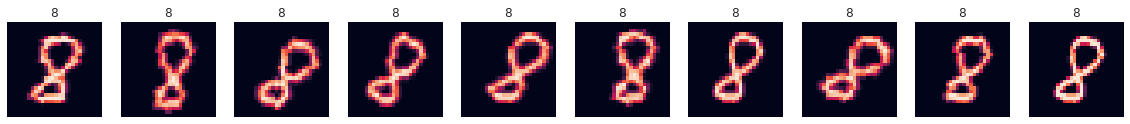

In [11]:
plt.figure(figsize=(20,10))
for i in range(10):  
    plt.subplot(1, 10, i+1)
    plt.imshow(dataset['train'][8]['digit'][0,:,:])
    plt.axis('off')
    plt.title(data['train'].iloc[8,0])
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  This is separate from the ipykernel package so we can avoid doing imports until


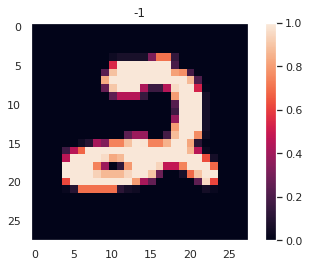

In [12]:
plt.imshow(dataset['test'][0]['digit'][0,:,:])
plt.grid(False)
plt.colorbar()
plt.title(dataset['test'][0]['label'])
plt.show()

# Dataloader

In [13]:
dataloader={
    'train':
    torch.utils.data.DataLoader(
        dataset['train'],
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=os.cpu_count(),
        pin_memory=True
    ),
    'val':
    torch.utils.data.DataLoader(
        dataset['val'],
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=os.cpu_count(),
        pin_memory=True
    ),
    'test':
    torch.utils.data.DataLoader(
        dataset['test'],
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=os.cpu_count(),
        pin_memory=True
    )
}

In [14]:
# 動作確認
next(iter(dataloader["test"]))  # 1番目の要素を取り出す


{'digit': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
    

# Model

In [15]:
#https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
# 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10
# with 40% dropout, batch normalization, and data augmentation added

In [16]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv=torch.nn.Sequential(
            torch.nn.Conv2d(1,32,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32,32,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32,32,5,2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout(0.4),
            
            torch.nn.Conv2d(32,64,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64,64,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64,64,5),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout(0.4),
            
        )
        
        self.flatten = torch.nn.Flatten()
        
        self.linear=torch.nn.Sequential(
            torch.nn.Linear(256,10)
        )
        
        self.softmax=torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = self.conv(x)
        x=self.flatten(x)
        x=self.linear(x)
        x=self.softmax(x)
        return x

In [17]:
cnn=CNN()
cnn.to(CFG.device)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.4, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (17): ReLU()
    (18): BatchNorm2d(64, eps=1e

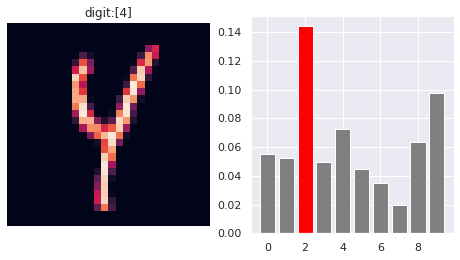

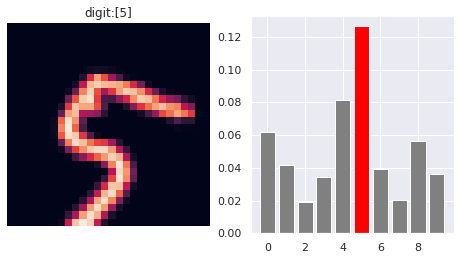

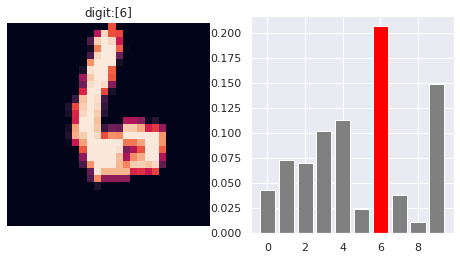

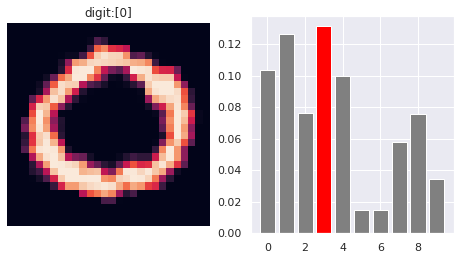

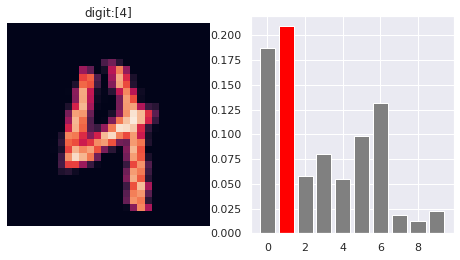

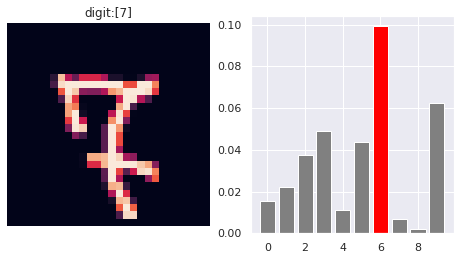

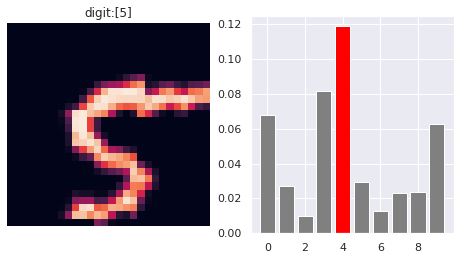

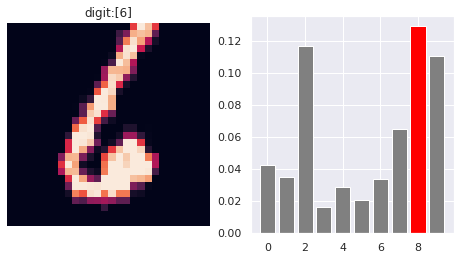

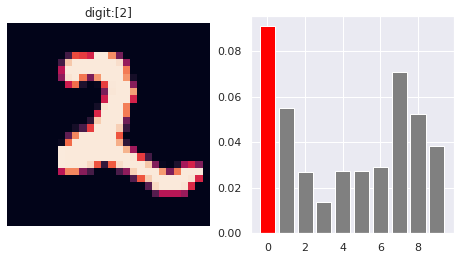

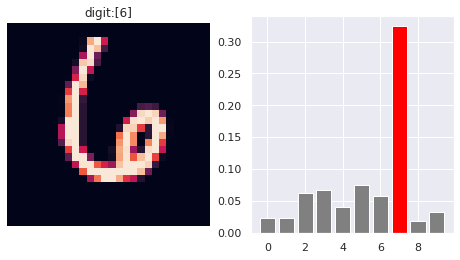

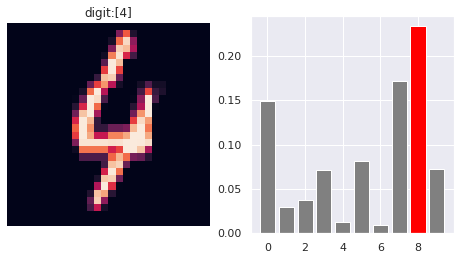

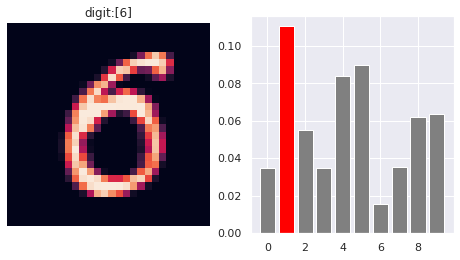

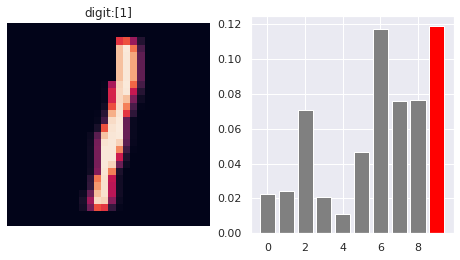

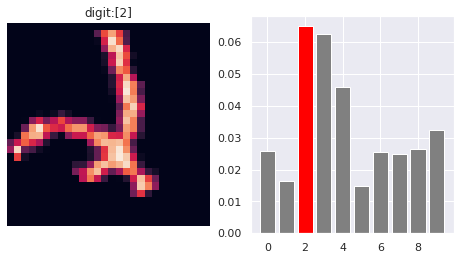

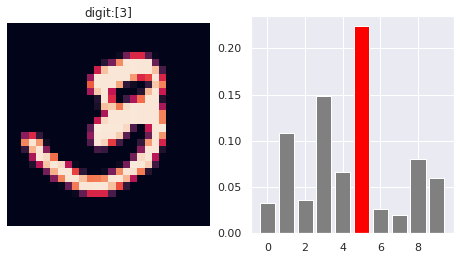

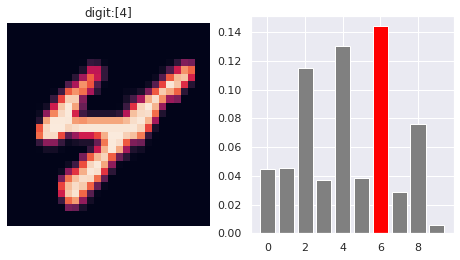

In [18]:
for batch in dataloader['train']:
    digit=batch['digit'].to(CFG.device)
    target=batch['label'].to(CFG.device)
    
    pre=cnn(digit)
    
    for i in range(CFG.batch_size):
        plt.figure(figsize=(8,4))
 
        plt.subplot(1, 2, 1)
        plt.imshow(batch['digit'][i,0,:,:])
        plt.axis('off')
        plt.title(f"digit:[{target[i]}]")

        plt.subplot(1, 2, 2)
        plt.bar(np.arange(10),
                pre[i].cpu().detach().numpy(),
                color=['red' if (x == np.argmax(pre[i].cpu().detach().numpy())) else 'grey' for x in range(10)]
        )
        plt.show()

    break

# Trainer

In [19]:
class Trainer():

    def __init__(self):
        self.loss_fun=torch.nn.CrossEntropyLoss()
        self.score_fun=lambda pre,ground_truth:torch.eq(torch.argmax(pre),ground_truth)

        self.optimizer=None
        self.lr_scheduler=None
        self.scaler=torch.cuda.amp.GradScaler(enabled=CFG.amp) 

    
    def train_val_test(self,model,dataloader,phase,epoch=-1):

        model.train() if phase=='train' else model.eval()   # モデルのモード
        #model.to(CFG.device)

        predictions=[]
        losses=[]
        scores=[]

        # データローダーからミニバッチを取り出すループ

        #tqdm_bar=io.StringIO() file=tqdm_bar,desc=f"model description\n{epoch} {phase}"
        for batch in tqdm(dataloader):
            
            # optimizerを初期化
            if phase=='train':self.optimizer.zero_grad()

            # 順伝搬（forward）計算
            with torch.set_grad_enabled(phase=='train'):
 
                digits = batch['digit'].to(CFG.device,non_blocking=True)
                targets = batch['label'].to(CFG.device,non_blocking=True)

                with torch.cuda.amp.autocast(enabled=CFG.amp):

                    preds=model(digits)#,targets)

                    if phase!='test':
                        loss = self.loss_fun(preds,targets)  # 損失を計算
                        losses.append(loss.item())
 
                        score = self.score_fun(preds, targets).cpu().numpy()  # 正誤判定
                        scores.extend(score)

                # 訓練時はバックプロパゲーション
                if phase == 'train':
                    if CFG.amp:
                        #scalerの場合
                        self.scaler.scale(loss).backward() # ロスのバックワード
                        self.scaler.step(self.optimizer) # オプティマイザーの更新
                        self.scaler.update() # スケーラーの更新
                    else:
                        loss.backward()
                        self.optimizer.step()

            predictions.extend(np.argmax(preds.detach().cpu().numpy(),axis=1))

            del preds
            if phase!='test':del loss,score
            torch.cuda.empty_cache()
            gc.collect()

        return predictions,losses,scores

trainer=Trainer()

submission

In [20]:
trainer.optimizer=torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
predictions,losses,scores=trainer.train_val_test(cnn,dataloader['train'],'train',epoch=0)

100%|██████████| 2100/2100 [06:07<00:00,  5.72it/s]


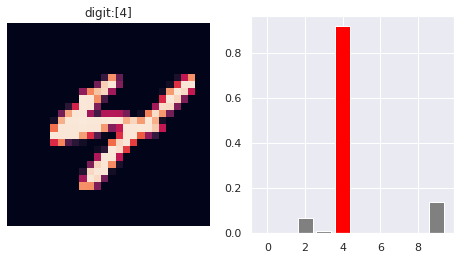

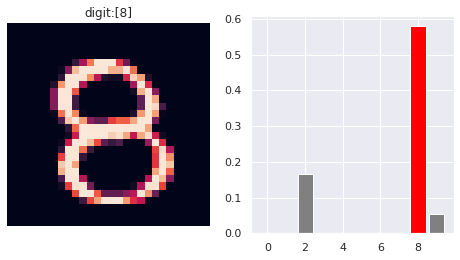

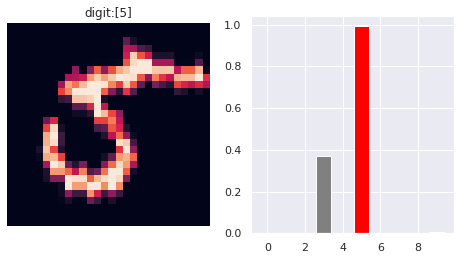

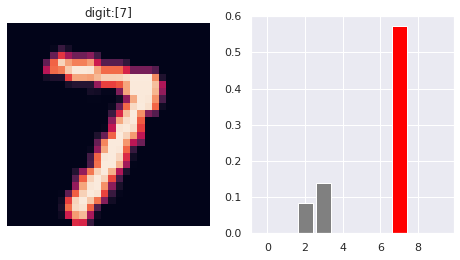

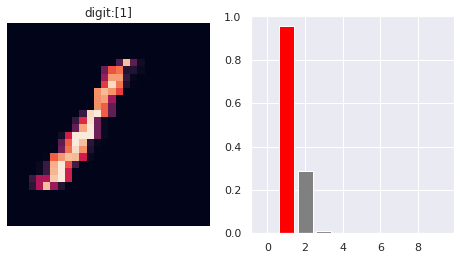

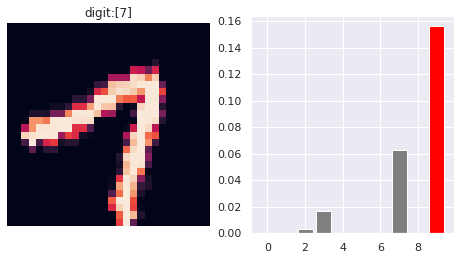

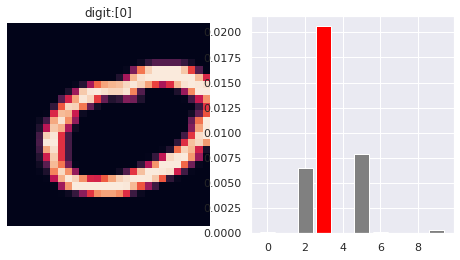

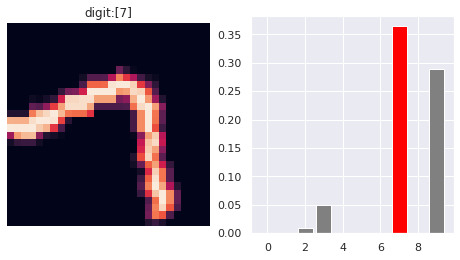

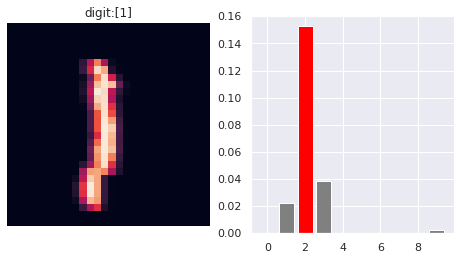

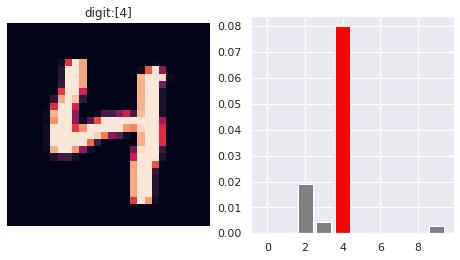

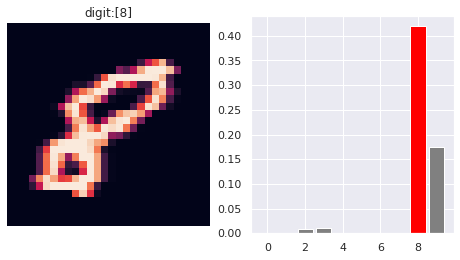

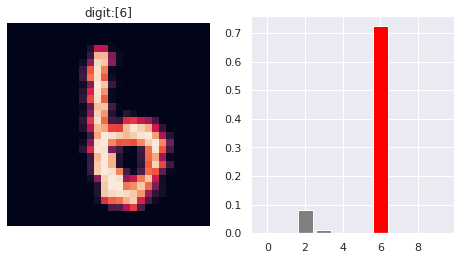

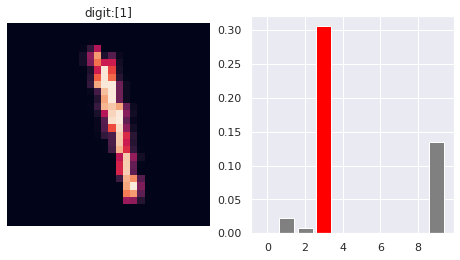

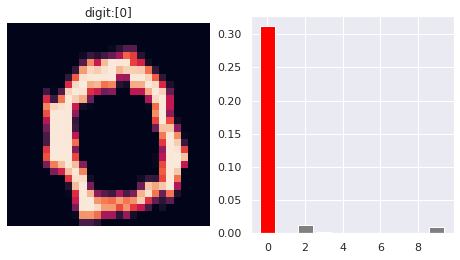

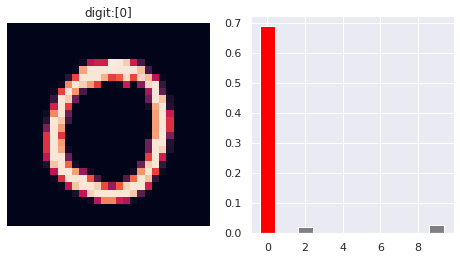

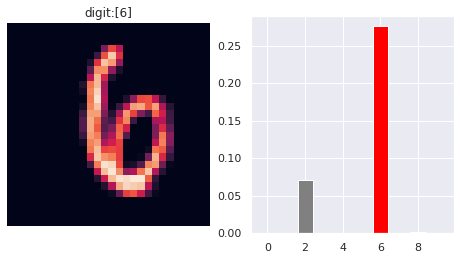

In [21]:
for batch in dataloader['val']:
    digit=batch['digit'].to(CFG.device)
    target=batch['label'].to(CFG.device)
    
    pre=cnn(digit)
    
    for i in range(CFG.batch_size):
        plt.figure(figsize=(8,4))
 
        plt.subplot(1, 2, 1)
        plt.imshow(batch['digit'][i,0,:,:])
        plt.axis('off')
        plt.title(f"digit:[{target[i]}]")

        plt.subplot(1, 2, 2)
        plt.bar(np.arange(10),
                pre[i].cpu().detach().numpy(),
                color=['red' if (x == np.argmax(pre[i].cpu().detach().numpy())) else 'grey' for x in range(10)]
        )
        plt.show()

    break

# Prediction

In [22]:
predictions,losses,scores=trainer.train_val_test(cnn,dataloader['test'],'test',epoch=0)
np.mean(scores)

100%|██████████| 1750/1750 [04:46<00:00,  6.10it/s]
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [23]:
submission=pd.DataFrame(index=sample_submission.index,columns=['Label'])
submission

,Label
ImageId,
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
27996,NaN
27997,NaN
27998,NaN


In [24]:
submission.Label=predictions
submission

,Label
ImageId,
1,2
2,6
3,8
4,6
5,1
...,...
27996,9
27997,0
27998,3


In [25]:
submission.to_csv("submission.csv",index=submission.index.name)